# Machine learning. Final Project, Team 26.

- Albert Matsiev
- Usman Tasuev
- Magomed-Emin Khatuev
- Ivan Kudryakov

## Brief Description

The recent success of DeepMind's AlphaCode has increased the ML community interest in the task of code generation. In this project, you will be replicating one of the earlier works on code generation - "Latent Predictor Networks for Code Generation".

## General Project Goals

The goal of this project is to replicate the article "Latent Predictor Networks for Code Generation" (2016), which introduces neural networks with LSTMs and structured-attention to generate pythonic code based on the MTG and Hearthstone card descriptions (see the attached github link for the sample examples from the dataset). On top of the introduced network, you will also need to implement simple benchmarks (also mentioned in the paper - seq-2-seq and attention-based models) for comparison. You can also find a more recent (and more accurate) variant of similar recurrent networks, and implement it as well for the same task. Report your code and results. 

## Tasks

- A working implementation of the Latent Predictor Networks trained on either Hearthstone or MTG datasets
- Detailed analysis of the results and comparison to the mentioned benchmarks
- For a higher score, find a more current work that can be applied for this task (can be anything, even Transformers like in AlphaCode), implement it and report the results.

## Grading

- 80%. working implementation of the Latent Predictor Networks trained on either Hearthstone or MTG datasets.
- 90%. Everything for 70% + detailed analysis of the results and comparison to the mentioned benchmarks
- Extra points if you find a more current work that can be applied for this task (can be anything, even Transformers like in AlphaCode), implement it and report the results.

## Supervisor

- Nina Mazyavkina

## Relevant papers

- dataset - https://github.com/deepmind/card2code
- paper - https://arxiv.org/pdf/1603.06744.pdf

## Models

In [1]:
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout, Layer, Dot, Softmax, Bidirectional, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

# https://keras.io/examples/generative/text_generation_gpt/

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# input_path = '/content/drive/MyDrive/SK_MSc/ML_fp/data/hearthstone/train_hs.in'
# output_path = '/content/drive/MyDrive/SK_MSc/ML_fp/data/hearthstone/train_hs.out'
# full_data_path = '/content/drive/MyDrive/SK_MSc/ML_fp/data/hearthstone/card_data_hs.txt'


input_path =  './data/hearthstone/train_hs.in'
output_path = './data/hearthstone/train_hs.out'

Latent predictor model

In [18]:
import keras
from keras import backend as K
from keras.layers import Layer, Dot, Softmax

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

Text import and tokenization

In [20]:
# # Load the input and target value files as text
# with open(input_path, 'r') as f:
#     input_text = f.read().splitlines()
    
# with open(output_path, 'r') as f:
#     target_text = f.read().splitlines()

# # Initialize a tokenizer and fit it on the input text
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(input_text)

# # Convert the input and target text to sequences of integers
# input_sequences = tokenizer.texts_to_sequences(input_text)
# target_sequences = tokenizer.texts_to_sequences(target_text)

# # Pad the input and target sequences to a fixed length
# max_len = 300
# input_sequences = pad_sequences(input_sequences, maxlen=max_len, padding='post', truncating='post')
# target_sequences = pad_sequences(target_sequences, maxlen=max_len, padding='post', truncating='post')

# # Load the input and target sequences into numpy arrays
# X = np.array(input_sequences)
# y = np.array(target_sequences)


### LPN model with 3 predictors

In [21]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

maximum_number_of_lines = 2500

# load input and target files
with open(input_path, 'r') as f:
    input_lines = f.readlines()[:maximum_number_of_lines]
with open(output_path, 'r') as f:
    target_lines = f.readlines()[:maximum_number_of_lines]

# define max input and output lengths
max_input_length = 300
max_output_length = 300

# tokenize input and target sequences
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_lines)
input_sequences = input_tokenizer.texts_to_sequences(input_lines)
input_vocab_size = len(input_tokenizer.word_index) + 1

target_tokenizer = Tokenizer()
target_tokenizer.fit_on_texts(target_lines)
target_sequences = target_tokenizer.texts_to_sequences(target_lines)
target_vocab_size = len(target_tokenizer.word_index) + 1

# pad input and target sequences
input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post', truncating='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_output_length, padding='post', truncating='post')

# split data into training and validation sets
input_train, input_val, target_train, target_val = train_test_split(input_sequences, target_sequences, test_size=0.2, random_state=42)

# create decoder input and target sequences
decoder_input_train = np.zeros((target_train.shape[0], max_output_length))
decoder_input_train[:, 1:] = target_train[:, :-1]

decoder_input_val = np.zeros((target_val.shape[0], max_output_length))
decoder_input_val[:, 1:] = target_val[:, :-1]

decoder_target_train = np.zeros((target_train.shape[0], max_output_length, target_vocab_size))
for i, sequence in enumerate(target_train):
    for j, index in enumerate(sequence):
        if j > 0:
            decoder_target_train[i, j - 1, index] = 1

# decoder_target_val = np.zeros((target_val.shape[0], max_output_length, target_vocab_size))
# for i, sequence in enumerate(target_val):
#     for j, index in enumerate(sequence):
#         if j > 0:
#             decoder_target_val[i, j - 1, index] = 1

In [22]:
# decoder_target_val = np.zeros((target_val.shape[0], max_output_length, target_vocab_size))
# for i, sequence in enumerate(target_val):
#     for j, index in enumerate(sequence):
#         if j > 0:
#             decoder_target_val[i, j - 1, index] = 1

In [23]:
# max_i = 30

# decoder_target_train = np.zeros((max_i+1, max_output_length, target_vocab_size))
# for i, sequence in enumerate(target_train):
#     if i > max_i:
#         break
#     for j, index in enumerate(sequence):
#         if j > 0:
#             decoder_target_train[i, j - 1, index] = 1


In [24]:
# decoder_target_val = np.zeros((max_i+1, max_output_length, target_vocab_size))
# for i, sequence in enumerate(target_val):
#     for j, index in enumerate(sequence):
#         if j > 0:
#             decoder_target_val[i, j - 1, index] = 1

In [25]:
decoder_target_train.shape[0]

426

In [26]:
from keras.layers import Input, Dense, Embedding, LSTM, Concatenate, Bidirectional
from keras.models import Model


# max_input_length = 300
# max_output_length = 300
# input_vocab_size = 2000
# target_vocab_size = target_vocab_size
embedding_dim1 = embedding_dim2 = embedding_dim3 = 300
hidden_units1 = hidden_units2 = hidden_units3 = 300
latent_dim1 = latent_dim2 = latent_dim3 = 200

# define input and output shapes
input_shape = (max_input_length,)
output_shape = (max_output_length,)

# define input layers
input_layer = Input(shape=input_shape, name='input')

# define predictor networks with attention mechanism
predictor1_embedding_layer = Embedding(input_dim=input_vocab_size, output_dim=embedding_dim1)(input_layer)
predictor1_lstm_layer = LSTM(units=hidden_units1, return_sequences=True)(predictor1_embedding_layer)
predictor1_attention_layer = Dot(axes=[2, 2])([predictor1_lstm_layer, predictor1_lstm_layer])
predictor1_attention_weights = Softmax(axis=1)(predictor1_attention_layer)
predictor1_context_vector = Dot(axes=[2, 1])([predictor1_attention_weights, predictor1_lstm_layer])
predictor1_merged_layer = Concatenate()([predictor1_context_vector, predictor1_lstm_layer])
predictor1_layer = Dense(units=latent_dim1)(predictor1_merged_layer)

predictor3_embedding_layer = Embedding(input_dim=input_vocab_size, output_dim=embedding_dim3)(input_layer)
predictor3_lstm_layer = LSTM(units=hidden_units3, return_sequences=True)(predictor3_embedding_layer)
predictor3_attention_layer = Dot(axes=[2, 2])([predictor3_lstm_layer, predictor3_lstm_layer])
predictor3_attention_weights = Softmax(axis=1)(predictor3_attention_layer)
predictor3_context_vector = Dot(axes=[2, 1])([predictor3_attention_weights, predictor3_lstm_layer])
predictor3_merged_layer = Concatenate()([predictor3_context_vector, predictor3_lstm_layer])
predictor3_layer = Dense(units=latent_dim3)(predictor3_merged_layer)

predictor2_embedding_layer = Embedding(input_dim=input_vocab_size, output_dim=embedding_dim2)(input_layer)
predictor2_lstm_layer = LSTM(units=hidden_units2, return_sequences=True)(predictor2_embedding_layer)
predictor2_lstm_layer = Bidirectional(LSTM(200, return_sequences=True))(predictor2_lstm_layer)
predictor2_attention_layer = Dot(axes=[2, 2])([predictor2_lstm_layer, predictor2_lstm_layer])
predictor2_attention_weights = Softmax(axis=1)(predictor2_attention_layer)
predictor2_context_vector = Dot(axes=[2, 1])([predictor2_attention_weights, predictor2_lstm_layer])
predictor2_merged_layer = Concatenate()([predictor2_context_vector, predictor2_lstm_layer])
predictor2_layer = Dense(units=latent_dim2)(predictor2_merged_layer)

# concatenate predictor outputs
merged_layer = Concatenate()([predictor1_layer, predictor2_layer, predictor3_layer])

# define generator network with attention mechanism
# generator_lstm_layer = LSTM(units=hidden_units3, return_sequences=True)(merged_layer)

# generator_attention_layer = Dot(axes=[2, 2])([generator_lstm_layer, generator_lstm_layer])
# generator_attention_weights = Softmax(axis=1)(generator_attention_layer)
# generator_context_vector = Dot(axes=[2, 1])([generator_attention_weights, generator_lstm_layer])
# merged_generator_layer = Concatenate()([generator_context_vector, generator_lstm_layer])
# output_layer = Dense(units=target_vocab_size, activation='softmax')(merged_generator_layer)

output_layer = Dense(100, activation="sigmoid")(merged_layer)
output_layer = Dense(100, activation="tanh")(output_layer)
output_layer = Dense(target_vocab_size, activation="softmax")(output_layer)


# define model
model = Model(inputs=input_layer, outputs=output_layer)

# compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



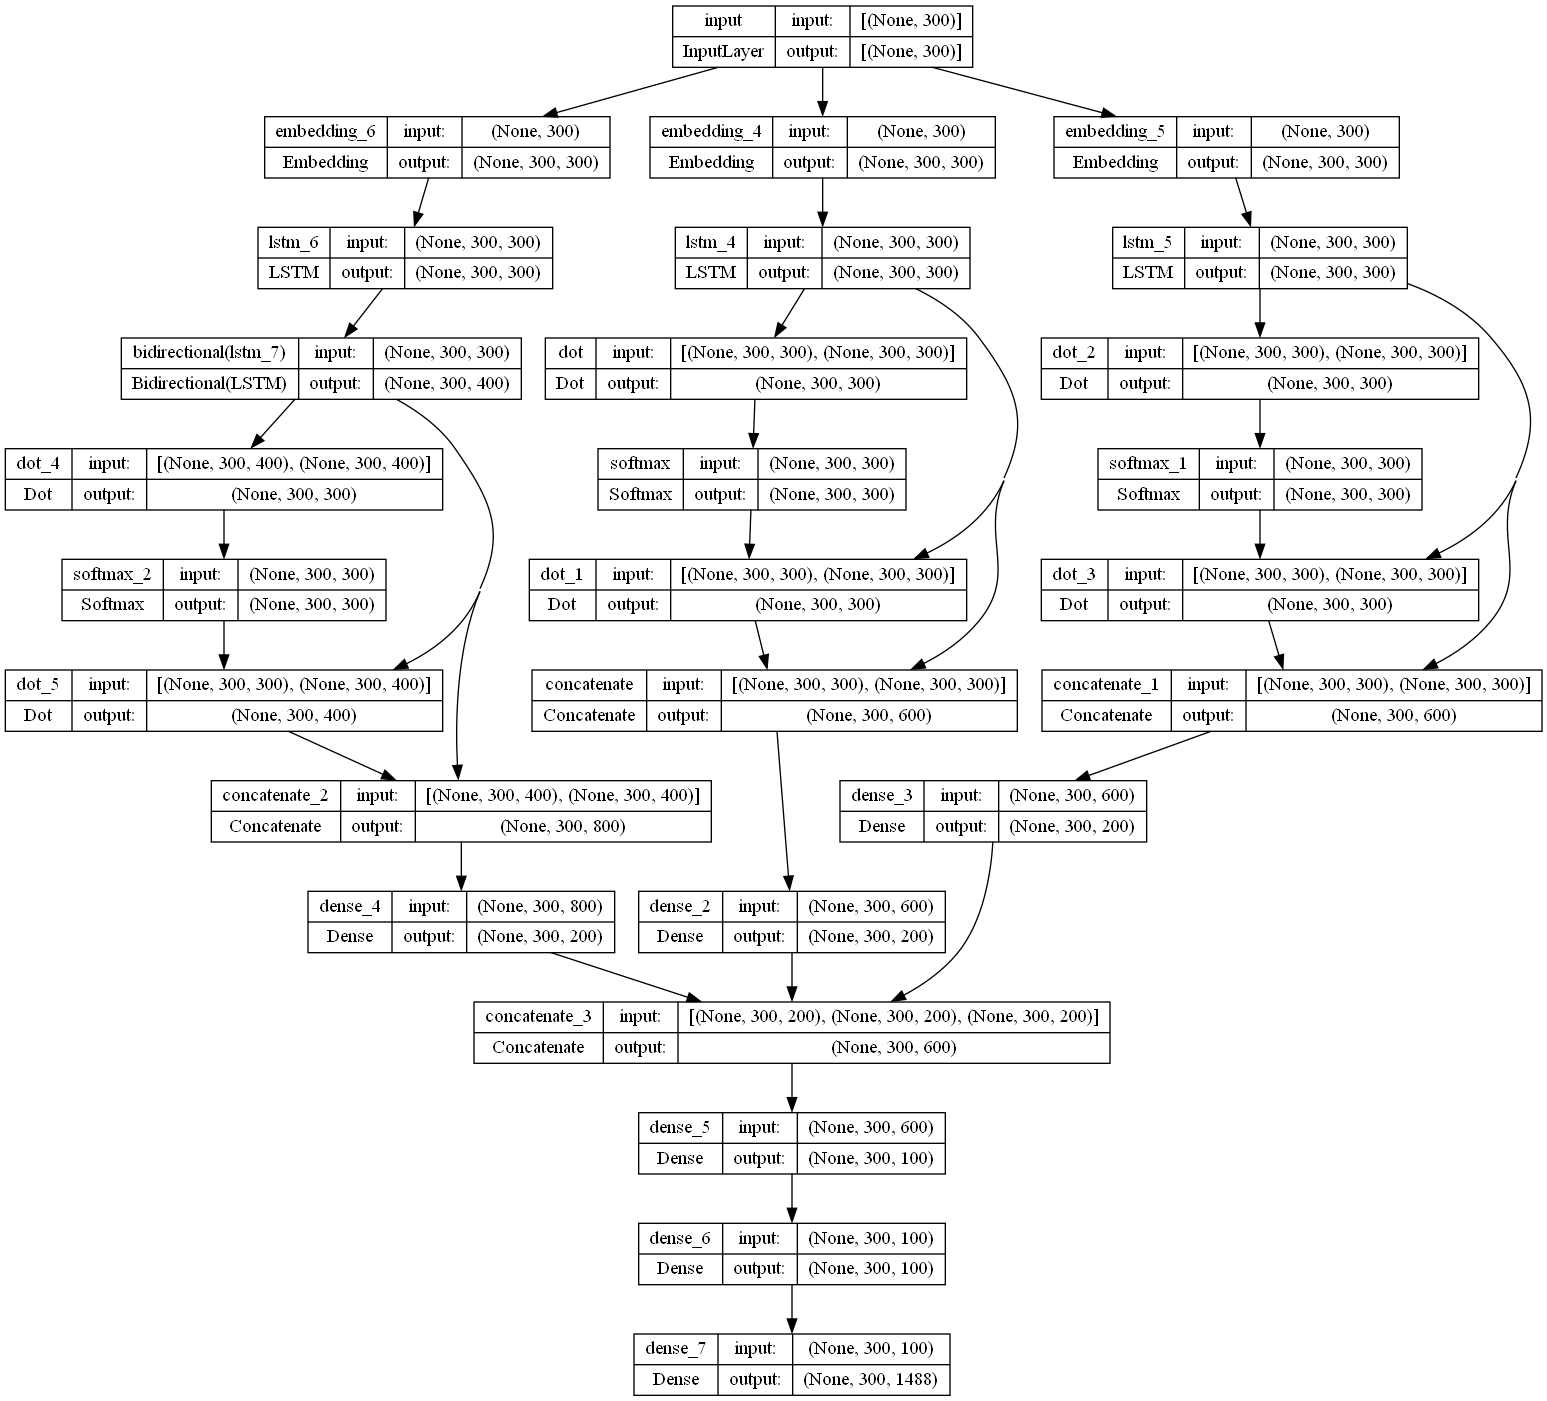

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file="latent_full_hs_bilstm.png",
    show_dtype=False,
    show_layer_names=True)

In [28]:
input_train.shape

(426, 300)

In [29]:
import random
from keras import optimizers
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')


optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy',])

epochs = 30
batch_size = 30

model.fit(input_train, decoder_target_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2, callbacks=[early_stop])

Epoch 1/30
12/12 [==============================] - 294s 24s/step - loss: 6.0563 - accuracy: 0.6183 - val_loss: 4.5929 - val_accuracy: 0.8446
Epoch 2/30
12/12 [==============================] - 296s 25s/step - loss: 3.6597 - accuracy: 0.8404 - val_loss: 2.4816 - val_accuracy: 0.8446
Epoch 3/30
12/12 [==============================] - 302s 25s/step - loss: 1.8990 - accuracy: 0.8404 - val_loss: 1.3445 - val_accuracy: 0.8446
Epoch 4/30
12/12 [==============================] - 275s 23s/step - loss: 1.4776 - accuracy: 0.7924 - val_loss: 1.0291 - val_accuracy: 0.8446
Epoch 5/30
12/12 [==============================] - 232s 19s/step - loss: 1.0114 - accuracy: 0.8404 - val_loss: 0.9171 - val_accuracy: 0.8446
Epoch 6/30
12/12 [==============================] - 229s 19s/step - loss: 0.9350 - accuracy: 0.8404 - val_loss: 0.8671 - val_accuracy: 0.8446
Epoch 7/30
12/12 [==============================] - 227s 19s/step - loss: 0.8951 - accuracy: 0.8404 - val_loss: 0.8363 - val_accuracy: 0.8446
Epoch 

In [30]:
model.save('./models/latent_full_hs_bilstm')

INFO:tensorflow:Assets written to: ./models/latent_full_hs_bilstm\assets


INFO:tensorflow:Assets written to: ./models/latent_full_hs_bilstm\assets


In [31]:
model = keras.models.load_model('./models/latent_full_hs_bilstm')

In [32]:
decoder_target_train[:,].shape

(426, 300, 1488)

In [33]:
y_pred_lpn = model.predict(input_val)

4/4 [==============================] - 31s 7s/step


In [34]:
# Define the reverse word index dictionary
reverse_word_index = dict([(value, key) for (key, value) in target_tokenizer.word_index.items()])

# Define a function to decode a one-hot encoded sequence to text
def decode_one_hot_sequence(sequence):
    # Find the index of the maximum value in each row
    indices = np.argmax(sequence, axis=1)
    
    # Map the indices to words using the reverse word index dictionary
    words = [reverse_word_index.get(index, '') for index in indices]
    
    # Join the words into a text string and return it
    text = ' '.join(words)
    return text
    
# Decode the first 20 one-hot encoded sequence in the validation set
for i in range(20):
    decoded_sequence = decode_one_hot_sequence(y_pred_lpn[i])
    print(decoded_sequence)
    print('\n')


minioncard minioncard в§ в§ init в§ в§ в§ init init class def character class class card rarity class minion minion minion minion minion player в§ в§ minion в§ в§ в§ в§ в§ в§ в§ в§ в§ в§ в§ в§ в§ в§ в§                                                                                                                                                                                                                                                                  


minioncard minioncard minioncard в§ в§ init в§ в§ в§ init init init class class class rarity rarity class minion minion minion minion minion minion в§ player player player в§ в§                                                                                                                                                                                                                                                                              


minioncard minioncard в§ в§ init в§ в§ в§ init init init class class class rarity rarity

### A sequence-to-sequence model (Sutskever et al., 2014)

In [102]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load input and target data
maximum_number_of_lines = 2500

with open(input_path, 'r') as f:
    input_text = f.readlines()[:maximum_number_of_lines]

with open(output_path, 'r') as f:
    target_text = f.readlines()[:maximum_number_of_lines]


target_text = [f'{item}\n' for item in target_text]
input_text = [f'{item}\n' for item in input_text]



text_tokenizer = Tokenizer(filters='', char_level=True)

# Add start and end tokens to word_counts
start_token = '<START>'
end_token = '<END>'
text_tokenizer.word_counts[start_token] = 0
text_tokenizer.word_counts[end_token] = 0


text_tokenizer.fit_on_texts(input_text + target_text)
# text_tokenizer.word_counts['\n'] = 0


input_sequences = text_tokenizer.texts_to_sequences(input_text)
target_sequences = text_tokenizer.texts_to_sequences(target_text)

max_input_len = max(len(seq) for seq in input_sequences)
max_target_len = max(len(seq) for seq in target_sequences)

encoder_input_sequences = pad_sequences(input_sequences, maxlen=max_input_len, padding='post')
decoder_input_sequences = pad_sequences(target_sequences, maxlen=max_target_len, padding='post')
encoder_input_sequences.shape

decoder_output_sequences = np.zeros_like(decoder_input_sequences)
decoder_output_sequences[:, 1:] = decoder_input_sequences[:, :-1]
decoder_output_sequences[:, 0] = text_tokenizer.word_index['\n']
decoder_output_one_hot = np.zeros((len(decoder_input_sequences), max_target_len, len(text_tokenizer.word_index)+1), dtype='float32')
for i, seq in enumerate(decoder_output_sequences):
    for j, token in enumerate(seq):
        decoder_output_one_hot[i, j, token] = 1.0

decoder_output_one_hot.shape

(533, 1933, 67)

In [103]:
# text_tokenizer.word_counts
text_tokenizer.index_word[0] = end_token
text_tokenizer.index_word[0] = start_token

# text_tokenizer.index_word

In [104]:
latent_dim = 200
vocab_size = len(text_tokenizer.word_counts) + 1

# Define the encoder and decoder LSTM layers
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(vocab_size, latent_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(vocab_size, latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the Seq2Seq model
model_seq2seq = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# model_seq2seq.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [105]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
optimizer = optimizers.Adam(learning_rate=0.003)
model_seq2seq.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy',])

epochs = 20
batch_size = 300

model_seq2seq.fit([encoder_input_sequences, decoder_input_sequences], decoder_output_one_hot, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stop])

Epoch 1/20
2/2 [==============================] - 240s 151s/step - loss: 4.0725 - accuracy: 0.2437 - val_loss: 2.0301 - val_accuracy: 0.8097
Epoch 2/20
2/2 [==============================] - 235s 149s/step - loss: 1.7692 - accuracy: 0.8142 - val_loss: 0.8636 - val_accuracy: 0.8089
Epoch 3/20
2/2 [==============================] - 236s 150s/step - loss: 0.8446 - accuracy: 0.8122 - val_loss: 0.8513 - val_accuracy: 0.8049
Epoch 4/20
2/2 [==============================] - 241s 155s/step - loss: 0.8268 - accuracy: 0.8096 - val_loss: 0.8137 - val_accuracy: 0.8104
Epoch 5/20
2/2 [==============================] - 242s 153s/step - loss: 0.7882 - accuracy: 0.8181 - val_loss: 0.7678 - val_accuracy: 0.8210
Epoch 6/20
2/2 [==============================] - 237s 152s/step - loss: 0.7435 - accuracy: 0.8306 - val_loss: 0.7690 - val_accuracy: 0.8446
Epoch 7/20
2/2 [==============================] - 237s 153s/step - loss: 0.7469 - accuracy: 0.8463 - val_loss: 0.6807 - val_accuracy: 0.8376
Epoch 8/20
2/

In [115]:
model_seq2seq.save('./models/seq2seq_hs')

INFO:tensorflow:Assets written to: ./models/seq2seq_hs\assets


INFO:tensorflow:Assets written to: ./models/seq2seq_hs\assets


#### Prediction

In [107]:
from tensorflow import keras

model_seq2seq = keras.models.load_model('./models/seq2seq_hs')

In [116]:
# Define the encoder model
encoder_model = Model(encoder_inputs, encoder_states)

# Define the decoder model
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)


def generate_output_sequence(input_seq):
    # Encode the input sequence using the encoder model
    states_value = encoder_model.predict(input_seq)

    # Generate the decoder input sequence with the start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = text_tokenizer.word_index['\n']

    # Generate the output sequence token by token
    decoded_sentence = ''
    while True:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        output_token = np.argmax(output_tokens[0, -1, :])
        new_char = text_tokenizer.index_word[output_token]
        decoded_sentence += new_char
        # print(decoded_sentence)
        if len(decoded_sentence) > max_output_length or new_char == '\n' or new_char == end_token:
            break
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = output_token
        states_value = [h, c]

    return decoded_sentence

In [117]:
# text_tokenizer.word_counts
text_tokenizer.index_word[0]
# text_tokenizer.word_index['\n']

'<START>'

In [120]:
test_input_path = './data/hearthstone/test_hs.in'
test_output_path = './data/hearthstone/test_hs.out'

test_lines = open(test_input_path, 'r').readlines()

In [119]:
test_seq = test_lines[0]

input_sequence = np.array([text_tokenizer.texts_to_sequences(test_seq)[0]])
output_sequence = generate_output_sequence(input_sequence)
print(output_sequence)

1/1 [==============================] - 0s 21ms/step
<START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START><START>


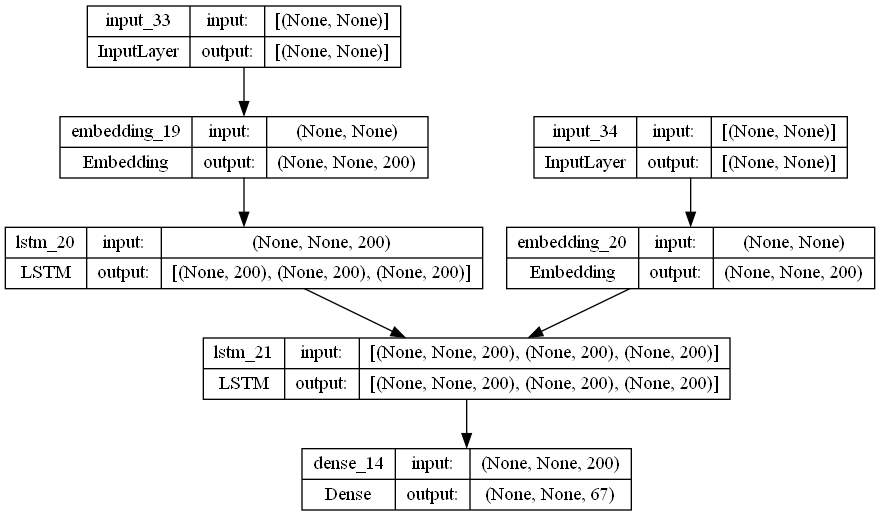

In [121]:
tf.keras.utils.plot_model(model_seq2seq, show_shapes=True, to_file='model_seq2seq.png',
    show_dtype=False,
    show_layer_names=True)

### Attention model (Bahdanau et al., 2014)

In [93]:
def get_attention_model(hidden_size=200, num_words=1664, embedding_dim=200, dropout=0.2):
    latent_dim = 200
    output_vocab_size = len(text_tokenizer.word_counts) + 1
    input_vocab_size = len(text_tokenizer.word_counts) + 1

    # Define the encoder and decoder LSTM layers
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_vocab_size, latent_dim)(encoder_inputs)
    encoder_lstm = LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(output_vocab_size, latent_dim)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

    # AdditiveAttention layer
    attention = AdditiveAttention()([decoder_outputs, encoder_outputs])

    decoder_dense = Dense(output_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

model_attention = get_attention_model()

In [94]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
optimizer = Adam(learning_rate=0.001)
model_attention.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy',])

epochs = 30
batch_size = 300

model_attention.fit([encoder_input_sequences, decoder_input_sequences], decoder_output_one_hot, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stop])

Epoch 1/30
2/2 [==============================] - 315s 195s/step - loss: 4.1500 - accuracy: 0.2427 - val_loss: 3.9179 - val_accuracy: 0.8309
Epoch 2/30
2/2 [==============================] - 289s 185s/step - loss: 3.8538 - accuracy: 0.8330 - val_loss: 3.3119 - val_accuracy: 0.8118
Epoch 3/30
2/2 [==============================] - 255s 155s/step - loss: 3.0293 - accuracy: 0.8154 - val_loss: 1.3149 - val_accuracy: 0.8097
Epoch 4/30
2/2 [==============================] - 237s 150s/step - loss: 1.2439 - accuracy: 0.8144 - val_loss: 1.2191 - val_accuracy: 0.8108
Epoch 5/30
2/2 [==============================] - 236s 150s/step - loss: 1.1950 - accuracy: 0.8165 - val_loss: 0.8674 - val_accuracy: 0.8147
Epoch 6/30
2/2 [==============================] - 239s 152s/step - loss: 0.8492 - accuracy: 0.8164 - val_loss: 0.8726 - val_accuracy: 0.8046
Epoch 7/30
2/2 [==============================] - 237s 150s/step - loss: 0.8533 - accuracy: 0.8089 - val_loss: 0.8712 - val_accuracy: 0.8029
Epoch 8/30
2/

KeyboardInterrupt: 

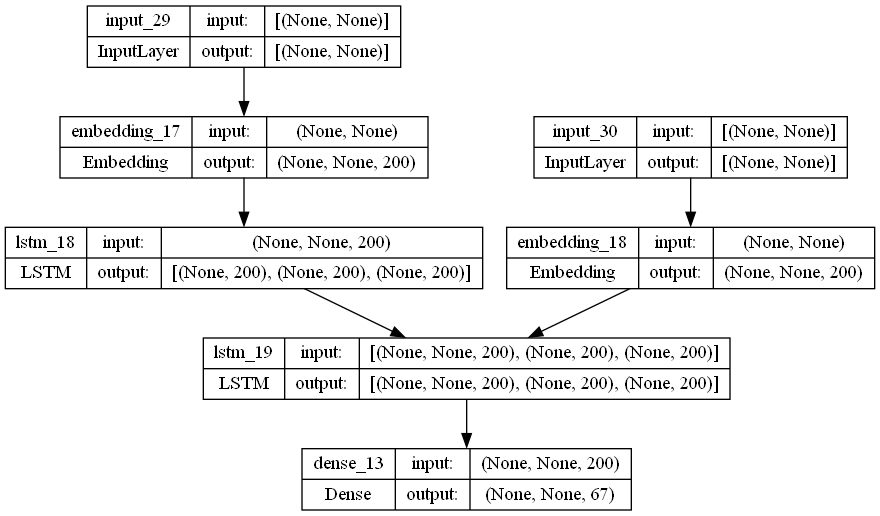

In [113]:
tf.keras.utils.plot_model(model_attention, show_shapes=True, to_file='./model_attention.png',
    show_dtype=False,
    show_layer_names=True)

In [114]:
model_attention.save('./models/attention_hs')

INFO:tensorflow:Assets written to: ./models/attention_hs\assets


INFO:tensorflow:Assets written to: ./models/attention_hs\assets


## Evaluation

For model evaluation we use accuracy, perplexity and bleu scores.

In [48]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import nltk
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import accuracy_score

### LPN model with 3 predictors

In [49]:
bleu_scores_lpn = []
for i in range(len(y_pred_lpn)):
    decoded_sequence = decode_one_hot_sequence(y_pred_lpn[i])
    val = target_tokenizer.sequences_to_texts(target_train)[i]
    bleu_score = sentence_bleu([val], decoded_sequence)
    bleu_scores_lpn.append(bleu_score)
bleu_scores_lpn = np.round(np.mean(bleu_scores_lpn), 2)

In [50]:
bleu_scores_lpn

0.22

In [51]:
accuracy_lpn = []

for i in range(len(y_pred_lpn)):
    decoded_sequence = decode_one_hot_sequence(y_pred_lpn[i])
    val = target_tokenizer.sequences_to_texts(target_train)[i]
    val_words = val.split()
    decoded_words = decoded_sequence.split()
    num_correct = 0
    for j in range(min(len(val_words), len(decoded_words))):
        if val_words[j] == decoded_words[j]:
            num_correct += 1
    acc_lpn = num_correct / max(len(val_words), len(decoded_words))
    accuracy_lpn.append(acc_lpn)

accuracy_lpn = np.round(np.mean(accuracy_lpn), 2)

In [52]:
accuracy_lpn

0.13

### Sequence model

In [136]:
bleu_scores_seq = []
for i in range(20):
    test_seq = test_lines[i]
    input_sequence = np.array([text_tokenizer.texts_to_sequences(test_seq)[i]])
    output_sequence = generate_output_sequence(input_sequence)
    bleu_score = sentence_bleu([test_seq], output_sequence)
    bleu_scores_seq.append(bleu_score)
bleu_scores_seq = np.round(np.mean(bleu_scores_seq), 2)

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


In [137]:
bleu_scores_seq

0.0

In [141]:
accuracy_seq = []

for i in range(20):
    test_seq = test_lines[i]
    input_sequence = np.array([text_tokenizer.texts_to_sequences(test_seq)[i]])
    output_sequence = generate_output_sequence(input_sequence)
    
    
    decoded_sequence = generate_output_sequence(input_sequence)
    val = test_seq
    val_words = val.split()
    decoded_words = decoded_sequence.split()
    
    num_correct = 0
    for j in range(min(len(val_words), len(decoded_words))):
        if val_words[j] == decoded_words[j]:
            num_correct += 1
    acc_seq = num_correct / max(len(val_words), len(decoded_words))
    accuracy_seq.append(acc_seq)

accuracy_seq = np.round(np.mean(accuracy_seq), 2)

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


### Scores table

In [143]:
data = [
    ["LPN", accuracy_lpn, bleu_scores_lpn],
    ["Sequence", accuracy_seq, bleu_scores_seq]
]
columns = ["Model", "Accuracy", "BLEU"]
 

In [144]:
results = pd.DataFrame(data, columns=columns)

In [145]:
results

,Model,Accuracy,BLEU
0,LPN,0.13,0.22
1,Sequence,0.00,0.00
